In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import re
from collections import defaultdict

In [2]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [3]:
# Modules for signal transform
from tsfresh import feature_extraction
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

In [4]:
# Consts
n_treads = 4 # used in sklearn and tsfresh
n_params = 90 # Params to remain in dataset
rndst = 4

In [5]:
def normalize_signal(signal, min_max=False):
    """
    signal - np.array or pd.Series with signal values
    
    Returns normalized TS: (TS - mean(TS))/std(TS)
    """
    if signal.name == 'delta':
        return signal / 180
    if min_max:
        return (signal - signal.min()) / (signal.max() - signal.min())
    std = np.std(signal)
    norm_signal = (signal - np.mean(signal)) / std if std else 1
    return norm_signal

In [6]:
def normalize_all_signals_in_ds(one_group_ds, min_max=1):
    global counter
    counter += 1
    for signal in one_group_ds.drop('t', axis=1):
#         if signal in ['Ug', 'Pg']:
#             one_group_ds[signal] = one_group_ds[signal] / one_group_ds[signal][0] - 1
#         else:
            one_group_ds[signal] = normalize_signal(one_group_ds[signal], min_max)

In [7]:
# os.chdir('..')
os.getcwd()

'/home/poligon/master_degree'

In [8]:
# labels = pd.DataFrame(columns=['id', 'class', 'label'])
# labels.columns
# labels.append((pd.Series( [1, 2, 3], index=labels.columns)), ignore_index=True)
# # dfObj.append(pd.Series(['Raju', 21, 'Bangalore', 'India'], index=dfObj.columns ), ignore_index=True)

In [9]:
def append_signals_dataset(data_directory, signals_dataset = None, labels = None, min_max_norm=True):
    data_dir_list = os.listdir(data_directory)
    os.chdir(data_directory)
    if labels is None:
        signal_id = 0
        labels = pd.DataFrame(columns=['id', 'class', 'label'])
    else:
        signal_id = labels.id.max() + 1
    for signal_label, directory in enumerate(data_dir_list):
        if os.path.isfile(directory) or directory[0] == '.':
                continue
        os.chdir(directory)
        for filename in os.listdir(os.curdir):
            if re.match(r'(.*csv)', filename):
#                 print(f'>>{filename}')
                if (signals_dataset) is not None:
                    tmp_df = pd.read_csv(filename)
                    normalize_all_signals_in_ds(tmp_df, min_max_norm)
                    tmp_df['id'] = signal_id
                    signals_dataset = signals_dataset.append(tmp_df, ignore_index=True)
                else:
                    signals_dataset = pd.read_csv(filename)
                    normalize_all_signals_in_ds(signals_dataset, min_max_norm)
                    signals_dataset['id'] = signal_id
#                 print(signals_dataset.head(5))
                tmp_labels = pd.Series([signal_id, directory, np.int(signal_label)],
                                         index=labels.columns)
                labels = labels.append(tmp_labels, ignore_index=True)
                signal_id += 1
        os.chdir('../')
    os.chdir('../..')
    return signals_dataset, labels

Data preprocessing:
    - dropping U.1 == U
    - changing type
    - generating features

In [10]:
# os.chdir('../')
os.getcwd()

'/home/poligon/master_degree'

In [11]:
# Dataset for first gen
counter = 0
dataset, labels = append_signals_dataset('./data/gen_1_25')
dataset, labels = append_signals_dataset('./data/gen_3_25', dataset, labels)
# dataset, labels = append_signals_dataset('./data/gen_1_80', dataset, labels)
# Dataset for second gen
dataset_2, labels_2 = append_signals_dataset('./data/gen_4_80')
# dataset_2, labels_2 = append_signals_dataset('./data/gen_2_80', dataset_2, labels_2)
# dataset_2, labels_2 = append_signals_dataset('./data/gen_3_80', dataset_2, labels_2)

In [12]:
labelizer = LabelEncoder().fit(labels['class'])
def normalize_labels(labels_df):
    """
    Разметим все классы числами от 0 до количества классов
    и преобразуем новую колонку в формат чисел (float)
    """
#     labels_df['label'] = labelizer.transform(labels_df['class'])
    labels_df['label'] = labels_df['class'].replace({'le_8': 0,
                        'more_8': 1,
                        'more_20': 2,
                       })
#     labels_df.index = labels_df['id']
#     labels_df.drop(columns=['id'])

In [13]:
print("Уникальные классы в датасете:", np.unique(labels['class']))
normalize_labels(labels)
normalize_labels(labels_2)
labels.sample(5)

Уникальные классы в датасете: ['le_8' 'more_20' 'more_8']


,id,class,label
14,14,more_20,2
36,36,more_8,1
7,7,more_20,2
32,32,more_8,1
56,56,le_8,0


In [14]:
labels_2.label.value_counts()

1    21
0    18
2    15
Name: label, dtype: int64

In [15]:
dataset.isna().sum()

t            0
Ug           0
Us           0
Pij          0
Pg           0
Pgt      20200
delta        0
id           0
dtype: int64

In [16]:
dataset.columns

Index(['t', 'Ug', 'Us', 'Pij', 'Pg', 'Pgt', 'delta', 'id'], dtype='object')

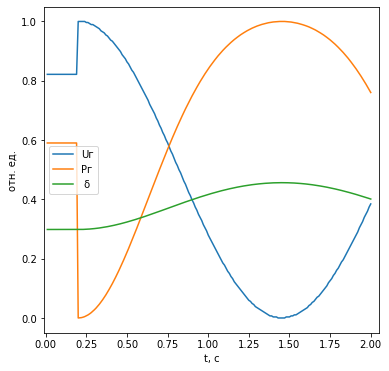

In [17]:
ex = dataset.query('id == 35')
fig = plt.figure(figsize=(6,6))
ax = plt.axes()
x_label = 't, с'
plt.plot(ex['t'], ex['Ug'], label='Uг')
plt.plot(ex['t'], ex['Pg'], label='Pг')
plt.plot(ex['t'], ex['delta'], label=' δ')
plt.xlim(-0.01, 2.05)
plt.xlabel(x_label)
plt.ylabel('отн. ед.')
plt.legend(loc='best')

plt.show()

In [18]:
# Удалим колонки которые не несут достаточной информации (повторяют значения, не изменяются)
# или могут быть некорректны
def drop_columns(dataset):
    mod_dataset = dataset.drop(['Us', 'Pgt', 'Pij'], axis=1)
    mod_dataset.index.name = 'tmp_id'
    return mod_dataset
mod_dataset = drop_columns(dataset)
mod_dataset_2 = drop_columns(dataset_2)
# Проверим возможность склеить сигнал с метками
mod_dataset.head(5)

,t,Ug,Pg,delta,id
tmp_id,,,,,
0,0.01,0.786561,0.575077,0.282944,0
1,0.02,0.786561,0.575077,0.282944,0
2,0.03,0.786561,0.575077,0.282944,0
3,0.04,0.786561,0.575077,0.282944,0
4,0.05,0.786561,0.575077,0.282944,0


In [19]:
def extract_signal_features(df, labels_df, feat_selection=True, signal_list=['Ug', 'Pg', 'delta']):
    features = defaultdict()
    for param in signal_list:
#     mod_dataset[param] = mod_dataset[param].astype('float')
        features[param] = feature_extraction.extract_features\
        (df.loc[:,[param,'id','t']], column_sort='t', column_id='id', n_jobs=n_treads)
        impute(features[param])
        if feat_selection:
            features[param] = select_features(features[param], labels_df['label'], ml_task='classification', n_jobs=n_treads)
    return features

In [20]:
features = extract_signal_features(mod_dataset, labels)

Feature Extraction: 100%|██████████| 17/17 [01:21<00:00,  4.80s/it]
/home/poligon/master_degree/tsfresh/utilities/dataframe_functions.py:170: RuntimeWarning: The columns ['delta__friedrich_coefficients__m_3__r_30__coeff_0'
 'delta__friedrich_coefficients__m_3__r_30__coeff_1'
 'delta__friedrich_coefficients__m_3__r_30__coeff_2'
 'delta__friedrich_coefficients__m_3__r_30__coeff_3'
 'delta__max_langevin_fixed_point__m_3__r_30'] did not have any finite values. Filling with zeros.
  df.iloc[:, np.where(is_col_non_finite)[0]].columns.values), RuntimeWarning)


Извлечем те же признаки для проверочного датасета, который модель никогда не видела

In [21]:
features_val = extract_signal_features(mod_dataset_2, labels_2, False)

Feature Extraction: 100%|██████████| 18/18 [00:42<00:00,  2.35s/it]
/home/poligon/master_degree/tsfresh/utilities/dataframe_functions.py:170: RuntimeWarning: The columns ['Ug__friedrich_coefficients__m_3__r_30__coeff_0'
 'Ug__friedrich_coefficients__m_3__r_30__coeff_1'
 'Ug__friedrich_coefficients__m_3__r_30__coeff_2'
 'Ug__friedrich_coefficients__m_3__r_30__coeff_3'
 'Ug__max_langevin_fixed_point__m_3__r_30'] did not have any finite values. Filling with zeros.
  df.iloc[:, np.where(is_col_non_finite)[0]].columns.values), RuntimeWarning)
Feature Extraction: 100%|██████████| 18/18 [00:49<00:00,  2.77s/it]
/home/poligon/master_degree/tsfresh/utilities/dataframe_functions.py:170: RuntimeWarning: The columns ['Pg__friedrich_coefficients__m_3__r_30__coeff_0'
 'Pg__friedrich_coefficients__m_3__r_30__coeff_1'
 'Pg__friedrich_coefficients__m_3__r_30__coeff_2'
 'Pg__friedrich_coefficients__m_3__r_30__coeff_3'
 'Pg__max_langevin_fixed_point__m_3__r_30'] did not have any finite values. Filling wi

### Отбор признаков и формирование эквивалентных датасетов
После обработки каждого сигнала библиотекой tsfresh извлекаем всевозможные признаки, признаки классифицированы по сигналу, из которого были получены (словарь features)

В конечном счете для каждого сигнала сформирован следующий набор данных:

In [22]:
for param in features:
    print("Для параметра", param, "получено", features[param].shape[1], "признака(ов).")

Для параметра Ug получено 541 признака(ов).
Для параметра Pg получено 609 признака(ов).
Для параметра delta получено 670 признака(ов).


In [23]:
# Пример хранящихся признаков
features['Ug'].columns.values[np.random\
                              .randint(0, 
                                       features['Ug'].shape[1],
                                       20)]

array(['Ug__energy_ratio_by_chunks__num_segments_10__segment_focus_3',
       'Ug__quantile__q_0.2',
       'Ug__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0',
       'Ug__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_7__w_5',
       'Ug__autocorrelation__lag_3',
       'Ug__fft_coefficient__coeff_79__attr_"real"',
       'Ug__quantile__q_0.7',
       'Ug__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"stderr"',
       'Ug__fft_coefficient__coeff_61__attr_"imag"',
       'Ug__fft_coefficient__coeff_34__attr_"real"',
       'Ug__fft_coefficient__coeff_90__attr_"abs"',
       'Ug__fft_coefficient__coeff_80__attr_"abs"',
       'Ug__linear_trend__attr_"slope"',
       'Ug__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_5__w_5',
       'Ug__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8',
       'Ug__fft_coefficient__coeff_33__attr_"real"',
       'Ug__fft_coefficient__coeff_77__attr_"abs"',
       'Ug__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_7__w_2'

## Поиск наиболее важных признаков, которые позволят предсказывать результат переходного процесса

In [24]:
# Удаляем фичи количество признаков в которых меньше количества классов
def clear_useless_features(features, threshold=3):
    for feature in features.columns:
        if features[feature].nunique() <= threshold \
            or features[feature].isna().sum():
            features = features.drop(feature, axis=1)
    return features

In [25]:
modified_features = defaultdict()
for param in features:
    modified_features[param] = clear_useless_features(features[param],
                                                     labels.label.nunique())
    print(f"Число удаленных признаков для {param}:",
          features[param].shape[1] - modified_features[param].shape[1])

Число удаленных признаков для Ug: 6
Число удаленных признаков для Pg: 9
Число удаленных признаков для delta: 8


Поиск признаков, имеющих наибольшую корреляцию с целевой переменной sklearn (Только для регресии и неотрицательных признаков)

In [26]:
def delete_negative_features(X):
    for i in X.columns:
        if X[i].min() < 0:
            X = X.drop(i, axis=1)
    return X

In [27]:
# X = delete_negative_features(modified_features['U'])
# X_2 = 
y = labels.label
# bestfeatures = SelectKBest(score_func=chi2, k=10)
# fit = bestfeatures.fit(X, labels.label)
# dfscores = pd.DataFrame(fit.scores_)
# dfcolumns = pd.DataFrame(X.columns)
# featureScores = pd.concat([dfcolumns,dfscores],axis=1)
# featureScores.columns = ['Specs','Score']  #naming the dataframe columns
# print(featureScores.nlargest(10,'Score'))

Использование дерева для поиска фич

In [28]:
def plot_features(X, y):
#     X = modified_features['U']
#     y = labels.label
    model = ExtraTreesClassifier(n_estimators=500, random_state=rndst)
    model.fit(X,y)
#     print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
    #plot graph of feature importances for better visualization
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.nlargest(10).plot(kind='barh')
    plt.xlabel('Оценка значимоссти')
    plt.ylabel('Переменная')
    plt.show()
    return feat_importances.nlargest(n_params)

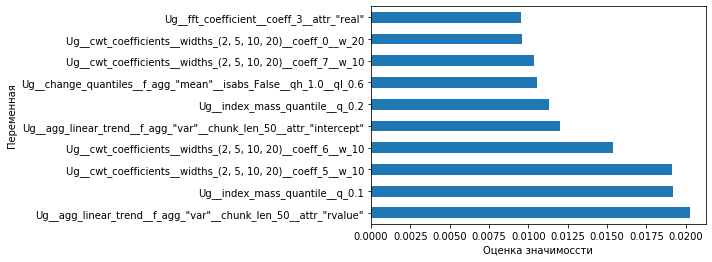

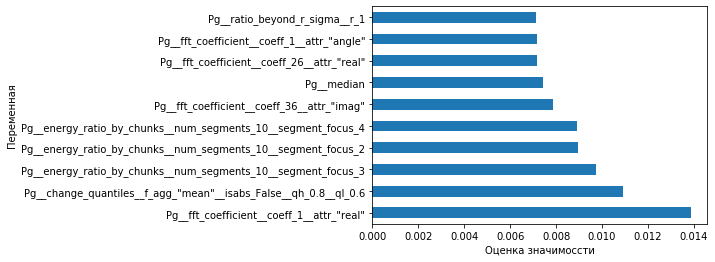

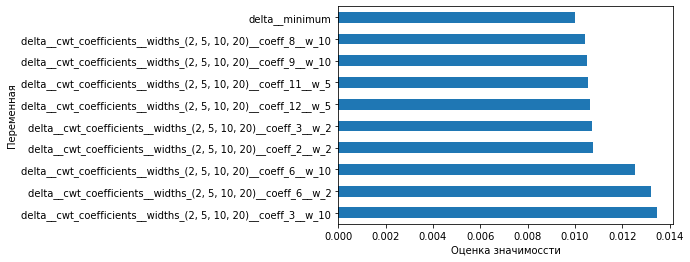

In [29]:
most_valuable_feat = dict([[feat, None] for feat in features])
for param in features:
    most_valuable_feat[param] = (plot_features(modified_features[param].astype('float32'), labels.label))

In [30]:
# Создаем датафрэйм с индексами, который будем доплнять самыми релевантными фичами
def remain_relevant_features(features):
    resulted_df = pd.DataFrame(index=features['Ug'].index)
    # Дополняем датафрэйм
    for param in features:
        for feat in features[param]:
            if feat in most_valuable_feat[param]:
#                 if most_valuable_feat[param][feat] >= 0.008:
                    resulted_df = pd.concat([resulted_df, features[param][feat]], axis=1)
    return resulted_df

In [31]:
def join_signal_features(features):
    resulted_df = pd.DataFrame(index=features['Ug'].index)
    # Дополняем датафрэйм
    for param in features:
        for feat in features[param]:
            resulted_df = pd.concat([resulted_df, features[param][feat]], axis=1)
    return resulted_df

In [32]:
# Выведем первые две строки получившегося датафрэйма
resulted_df = remain_relevant_features(features)
resulted_df.head(2)

,"Ug__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_5__w_10","Ug__fft_coefficient__coeff_19__attr_""real""","Ug__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_6__w_10","Ug__agg_linear_trend__f_agg_""var""__chunk_len_50__attr_""rvalue""","Ug__fft_coefficient__coeff_3__attr_""real""","Ug__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_4__w_10","Ug__fft_coefficient__coeff_20__attr_""real""","Ug__fft_coefficient__coeff_3__attr_""angle""","Ug__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_7__w_10","Ug__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_20",...,"delta__fft_coefficient__coeff_24__attr_""angle""",delta__approximate_entropy__m_2__r_0.7,"delta__agg_linear_trend__f_agg_""var""__chunk_len_5__attr_""rvalue""","delta__agg_linear_trend__f_agg_""var""__chunk_len_10__attr_""rvalue""","delta__agg_linear_trend__f_agg_""var""__chunk_len_50__attr_""rvalue""","delta__fft_coefficient__coeff_1__attr_""angle""",delta__count_above_mean,delta__longest_strike_below_mean,delta__count_below_mean,delta__longest_strike_above_mean
id,,,,,,,,,,,,,,,,,,,,,
0,0.657114,0.755949,0.769167,-0.431112,-1.734249,0.522359,0.674364,-102.385873,0.857243,-0.384502,...,111.832604,0.005399,-0.047492,-0.045574,-0.048526,92.323925,102.0,98.0,98.0,102.0
1,0.606452,0.761108,0.713753,-0.539858,-1.771619,0.477404,0.679939,-103.610867,0.798188,-0.421613,...,111.795840,0.006066,-0.074915,-0.077398,-0.094158,94.481583,103.0,97.0,97.0,103.0


In [33]:
print("Оставшиеся фичи:")
print(*resulted_df.columns[:10], sep='\n')

Оставшиеся фичи:
Ug__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_5__w_10
Ug__fft_coefficient__coeff_19__attr_"real"
Ug__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_6__w_10
Ug__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"rvalue"
Ug__fft_coefficient__coeff_3__attr_"real"
Ug__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_4__w_10
Ug__fft_coefficient__coeff_20__attr_"real"
Ug__fft_coefficient__coeff_3__attr_"angle"
Ug__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_7__w_10
Ug__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_20


## Постоение простейших моделей, градиентный бустинг и ансамбль решающих деревьев
Так как задача трансформировалась в задачу мультиклассификации, то воспользуемся методикой One-VS-All и построим модель для каждого отдельного класса

In [34]:
# OVA strategy
from sklearn.multiclass import OneVsRestClassifier
# OVO strategy
from sklearn.multiclass import OneVsOneClassifier
# Estimators for use in OVR (OVA)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB, BernoulliNB
from sklearn.svm import SVC
# Estimators with built-in OVR
from sklearn.svm import LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
# Model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
# Sklearn metrics
from sklearn import metrics
# Defaultdict
from collections import defaultdict

In [35]:
X = resulted_df
y = labels.label

In [36]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [37]:
resulted_df_val = join_signal_features(features_val).reindex(columns=X.columns)
X_test, y_test = resulted_df_val, labels_2.label

## Class for model evaluating

In [38]:
class ModelEvaluator():
    strategy_list = {'ovr': OneVsRestClassifier,
                     'ovo': OneVsRestClassifier}
    metric_list = {'f1_macro':
                       lambda y_true, y_pred: metrics.f1_score(y_true, y_pred, average='macro'),
                   'f1_micro':
                       lambda y_true, y_pred: metrics.f1_score(y_true, y_pred, average='micro'),
                   'accuracy': metrics.accuracy_score,
                   }
    
    def __init__(self, clf, strategy='ovr', n_jobs=4):
        """
        clf - classifier with fit, predict and predict_proba methods (classic)
        X_train, y_train - training dataset
        X_test, y_test - test dataset
        strategy - multiclasss Strategy OVO/OVR
        """
        if strategy.lower() not in self.strategy_list:
            raise AttributeError('Strategy must be OVR or OVO')
        self.strategy = strategy
        self.clf = self.strategy_list[strategy.lower()](clf, n_jobs)
        self.conf_matrix = None
        self.metrics = defaultdict()
    
    def count_metrics(self, y_true, y_pred):
        for metric_name, metric_func in self.metric_list.items():
            self.metrics[metric_name] = metric_func(y_true, y_pred)
    
    def evaluate(self, X_train, y_train, X_test, y_test, output=False):
        self.fit(X_train, y_train)
        y_pred = self.predict(X_test)
        self.conf_matrix = metrics.confusion_matrix(y_test, y_pred)
        self.count_metrics(y_test, y_pred)
        if output: print(*self.metrics.items(), sep='\n')
        
    def fit(self, X, y):
        self.clf.fit(X, y)
        
    def predict(self, X):
        return self.clf.predict(X)
    
    def predict_proba(self, X):
        if self.strategy == 'ovo':
            raise AttributeError('OVO strategy has no predict_proba!')
        return self.clf.predict_proba(X)
    
    def __repr__(self):
        sep = '-' * 10 + '\n'
        res = ''
        res += f'Strategy {self.strategy} with estimator:\n'
        res += str(self.clf.estimator) + '\n'
        res += sep
        if self.conf_matrix is not None:
            res += f'Confusion matrix:\n{self.conf_matrix}\n'
            res += sep
            res += '\n'.join([' '.join(list(map(str, pair))) for pair in self.metrics.items()])
        else:
            res += 'Model is not fitted'
        return res

### AdaBoost

In [39]:
ada = AdaBoostClassifier(n_estimators=70)
#                          base_estimator=GaussianNB(),
#                          learning_rate=0.001)

In [40]:
ada_ev = ModelEvaluator(ada)

In [41]:
ada_ev.evaluate(X, y, X_test, y_test)
ada_ev

Strategy ovr with estimator:
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=70, random_state=None)
----------
Confusion matrix:
[[18  0  0]
 [21  0  0]
 [ 2 13  0]]
----------
f1_macro 0.2033898305084746
f1_micro 0.3333333333333333
accuracy 0.3333333333333333

### Naive Bayes

In [42]:
gnb = GaussianNB()

In [43]:
gnb_ev = ModelEvaluator(gnb)

In [44]:
gnb_ev.evaluate(X, y, X_test, y_test)
gnb_ev

Strategy ovr with estimator:
GaussianNB(priors=None, var_smoothing=1e-09)
----------
Confusion matrix:
[[18  0  0]
 [19  0  2]
 [15  0  0]]
----------
f1_macro 0.1714285714285714
f1_micro 0.3333333333333333
accuracy 0.3333333333333333

### SVM (SVC)

In [45]:
svm_clf = SVC()

In [46]:
svm_ev = ModelEvaluator(svm_clf)

In [47]:
svm_ev.evaluate(X, y, X_test, y_test)
svm_ev

Strategy ovr with estimator:
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
----------
Confusion matrix:
[[18  0  0]
 [21  0  0]
 [15  0  0]]
----------
f1_macro 0.16666666666666666
f1_micro 0.3333333333333333
accuracy 0.3333333333333333

### GaussianProcess

In [48]:
gpc = GaussianProcessClassifier(multi_class = 'one_vs_one',
                                max_iter_predict=100
                               )
clf = gpc

In [49]:
clf.fit(X, y)

GaussianProcessClassifier(copy_X_train=True, kernel=None, max_iter_predict=100,
                          multi_class='one_vs_one', n_jobs=None,
                          n_restarts_optimizer=0, optimizer='fmin_l_bfgs_b',
                          random_state=None, warm_start=False)

In [50]:
y_pred = clf.predict(X_test)

In [51]:
y_true = np.array(y_test)
print("Accuracy:", metrics.accuracy_score(y_true, y_pred))
print("F1-macro:", metrics.f1_score(y_true, y_pred, average='macro'))
metrics.confusion_matrix(y_true, y_pred)

Accuracy: 0.3333333333333333
F1-macro: 0.16666666666666666


array([[18,  0,  0],
       [21,  0,  0],
       [15,  0,  0]])

### Ансамбль решающих деревьев
Так как задача трансформировалась в задачу мультиклассификации, то воспользуемся методикой One-VS-All и построим модель для каждого отдельного класса

In [52]:
rfc = RandomForestClassifier(n_estimators=500,
                             max_depth=5,
                             max_features='auto',
                             class_weight='balanced',
#                              bootstrap=False
                            )

In [53]:
rfc_ev = ModelEvaluator(rfc)

In [54]:
rfc_ev.evaluate(X, y, X_test, y_test)
rfc_ev

Strategy ovr with estimator:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
----------
Confusion matrix:
[[ 0 18  0]
 [ 0 21  0]
 [ 0 15  0]]
----------
f1_macro 0.18666666666666668
f1_micro 0.3888888888888889
accuracy 0.3888888888888889

### Градиентный бустинг

In [55]:
gbc = GradientBoostingClassifier(learning_rate=0.5,
                                 random_state=42,
                                 n_estimators=500,
                                 min_samples_leaf=3,
                                 max_depth=3)

In [56]:
gbc_ev = ModelEvaluator(gbc)

In [57]:
gbc_ev.evaluate(X, y, X_test, y_test)
gbc_ev

Strategy ovr with estimator:
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=3, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
----------
Confusion matrix:
[[11  7  0]
 [ 6 15  0]
 [14  1  0]]
----------
f1_macro 0.3769325912183055
f1_micro 0.48148148148148145
accuracy 0.48148148148148145

## For tests

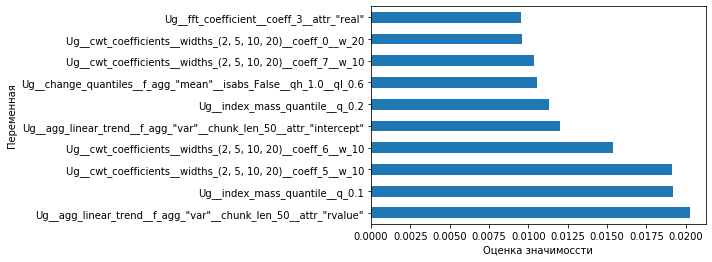

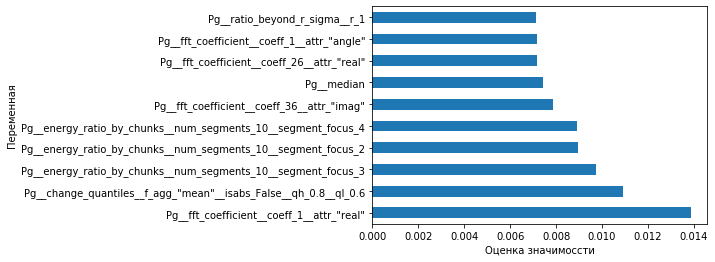

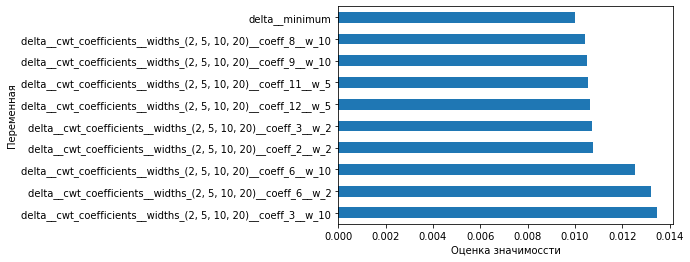

In [58]:
n_params = 70
rndst = 4
most_valuable_feat = dict([[feat, None] for feat in features])
for param in features:
    most_valuable_feat[param] = (plot_features(modified_features[param].astype('float32'), labels.label))

In [59]:
# Выведем первые две строки получившегося датафрэйма
resulted_df = remain_relevant_features(features)
resulted_df.head(2)

,"Ug__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_5__w_10","Ug__fft_coefficient__coeff_19__attr_""real""","Ug__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_6__w_10","Ug__agg_linear_trend__f_agg_""var""__chunk_len_50__attr_""rvalue""","Ug__fft_coefficient__coeff_3__attr_""real""","Ug__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_4__w_10","Ug__fft_coefficient__coeff_20__attr_""real""","Ug__fft_coefficient__coeff_3__attr_""angle""","Ug__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_7__w_10","Ug__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_20",...,delta__approximate_entropy__m_2__r_0.5,delta__approximate_entropy__m_2__r_0.9,delta__approximate_entropy__m_2__r_0.7,"delta__agg_linear_trend__f_agg_""var""__chunk_len_5__attr_""rvalue""","delta__agg_linear_trend__f_agg_""var""__chunk_len_10__attr_""rvalue""","delta__agg_linear_trend__f_agg_""var""__chunk_len_50__attr_""rvalue""","delta__fft_coefficient__coeff_1__attr_""angle""",delta__longest_strike_below_mean,delta__count_below_mean,delta__longest_strike_above_mean
id,,,,,,,,,,,,,,,,,,,,,
0,0.657114,0.755949,0.769167,-0.431112,-1.734249,0.522359,0.674364,-102.385873,0.857243,-0.384502,...,0.007152,0.004227,0.005399,-0.047492,-0.045574,-0.048526,92.323925,98.0,98.0,102.0
1,0.606452,0.761108,0.713753,-0.539858,-1.771619,0.477404,0.679939,-103.610867,0.798188,-0.421613,...,0.007898,0.004849,0.006066,-0.074915,-0.077398,-0.094158,94.481583,97.0,97.0,103.0


In [60]:
X = resulted_df
y = labels.label

In [61]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [62]:
resulted_df_val = join_signal_features(features_val).reindex(columns=X.columns)
X_test, y_test = resulted_df_val, labels_2.label

### CatBoost

In [59]:
from catboost import CatBoostClassifier

In [60]:
best_l2_reg = 1.6
best_lr = 0.86
best_n = 500

In [125]:

# Grid check leaf_reg
results = defaultdict()

for i in np.arange(0.65, 0.96, 0.01):
    cboost_clf = CatBoostClassifier(
                                    n_estimators=best_n,
                                    max_depth=3,
                                    learning_rate=i,
                                    loss_function='MultiClass',
                                    random_state=rndst,
    #                                 min_
                                    l2_leaf_reg=best_l2_reg
                                    )
    cboost_ev = ModelEvaluator(cboost_clf)
    cboost_ev.evaluate(X, y, X_test, y_test)
    results[i] = cboost_ev.metrics

In [128]:
def plot_grid_search(results):
    '''
    results - dict of searched values
    '''
    plt.figure(figsize=(8,6))
    acc = [i['accuracy'] for i in results.values()]
    f1 = [i['f1_macro'] for i in results.values()]
    plt.plot(list(results.keys()), acc, 'rv-')
    plt.plot(list(results.keys()), f1, 'bs--')
    plt.xlabel('Скорость обучения')
    plt.ylabel('Точность')
    plt.legend(['Средняя точность', 'Точность для класса'], loc='lower right')
    plt.show()

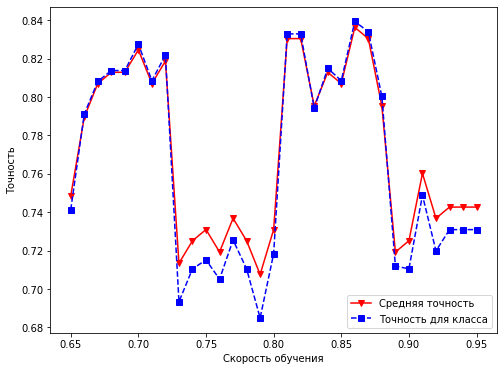

defaultdict(None,
            {0.65: defaultdict(None,
                         {'f1_macro': 0.7413241864108916,
                          'f1_micro': 0.7485380116959063,
                          'accuracy': 0.7485380116959064}),
             0.66: defaultdict(None,
                         {'f1_macro': 0.7910876153096505,
                          'f1_micro': 0.7894736842105263,
                          'accuracy': 0.7894736842105263}),
             0.67: defaultdict(None,
                         {'f1_macro': 0.8081608480013571,
                          'f1_micro': 0.8070175438596491,
                          'accuracy': 0.8070175438596491}),
             0.68: defaultdict(None,
                         {'f1_macro': 0.8137757087207094,
                          'f1_micro': 0.8128654970760234,
                          'accuracy': 0.8128654970760234}),
             0.6900000000000001: defaultdict(None,
                         {'f1_macro': 0.8137757087207094,
                     

In [129]:
plot_grid_search(results)
results

In [61]:
cboost_clf = CatBoostClassifier(
                                n_estimators=best_n,
                                max_depth=3,
                                learning_rate=best_lr,
                                loss_function='MultiClass',
                                random_state=rndst,
#                                 min_
                                l2_leaf_reg=best_l2_reg
                                )

In [62]:
cboost_ev = ModelEvaluator(cboost_clf)
clf = cboost_clf

In [63]:
cboost_ev.evaluate(X, y, X_test, y_test)

In [64]:
cboost_ev

Strategy ovr with estimator:
----------
Confusion matrix:
[[ 9  9  0]
 [ 0 21  0]
 [ 0 14  1]]
----------
f1_macro 0.4792735042735043
f1_micro 0.5740740740740741
accuracy 0.5740740740740741

In [65]:
clf = CatBoostClassifier(
                                n_estimators=300,
                                max_depth=3,
                                learning_rate=0.7,
                                loss_function='MultiClass',
                                random_state=4,
                                class_weights=[1.7,1,1],
                                l2_leaf_reg=4
                                )

In [66]:
# For searching optimal params
clf.fit(X_train, y_train,
        eval_set=(X_val, y_val),
        verbose=False);

In [67]:
y_pred = clf.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_true, y_pred))
metrics.confusion_matrix(y_true, clf.predict(X_test))

Accuracy: 0.5


array([[ 6, 12,  0],
       [ 0, 21,  0],
       [ 0, 15,  0]])

##### clf = cboost_ev

In [99]:
predicted_labels = pd.Series(clf.predict(X_test)).replace({0: 'le_8',
                        1: 'more_8',
                        2: 'more_20',
                       }).values.reshape(-1,1)
predicted_df = pd.DataFrame(np.concatenate([predicted_labels, clf.predict_proba(X_test)], axis=1),
                            index=labels_2.index,
                            columns=['predicted_class'] + list(['le_8', 'more_8', 'more_20']),
                           )
cboost_res = pd.concat(
          [labels_2,
           predicted_df
          ],
          axis=1)
cboost_res.sample(10)

,id,class,label,predicted_class,le_8,more_8,more_20
61,61,more_20,2,more_20,7.78606e-06,0.494097,0.505895
90,90,more_8,1,more_8,1.09289e-05,0.713772,0.286217
78,78,more_8,1,more_8,1.57065e-05,0.757036,0.242948
46,46,le_8,0,le_8,0.900818,0.0991528,2.89776e-05
8,8,more_20,2,more_20,1.30004e-05,0.00197463,0.998012
56,56,le_8,0,more_8,0.0110861,0.987458,0.00145578
110,110,more_20,2,more_8,0.000286923,0.762157,0.237556
94,94,le_8,0,le_8,0.999856,0.000120819,2.34417e-05
118,118,more_20,2,more_20,0.000990711,0.311197,0.687812
19,19,more_8,1,more_20,1.59345e-05,6.32806e-05,0.999921


In [100]:
cboost_res[cboost_res['class'] != cboost_res['predicted_class']]

,id,class,label,predicted_class,le_8,more_8,more_20
15,15,more_8,1,more_20,1.60078e-05,8.9364e-05,0.999895
16,16,more_8,1,more_20,4.18563e-05,0.0624897,0.937468
19,19,more_8,1,more_20,1.59345e-05,6.32806e-05,0.999921
22,22,more_8,1,more_20,1.47391e-05,0.00016207,0.999823
23,23,more_8,1,more_20,1.28743e-05,0.000224952,0.999762
24,24,more_8,1,more_20,1.30173e-05,0.000619101,0.999368
30,30,more_8,1,more_20,1.28684e-05,0.000215797,0.999771
33,33,more_8,1,more_20,1.49143e-05,0.000216877,0.999768
34,34,more_8,1,more_20,1.60051e-05,9.97088e-05,0.999884
38,38,more_8,1,more_20,1.68829e-05,0.00120644,0.998777


In [76]:
clf.predict(X_val).reshape(1,-1)

array([[1, 0, 2, 2, 0, 1, 1, 0, 2, 2, 1]])

In [77]:
y_val.values

array([1, 0, 2, 2, 0, 1, 1, 0, 2, 2, 1])

In [78]:
labelizer.classes_[1]

'more_20'

Гит комит

In [79]:
# !git status
# !git add .
# !git commit -m "Added another generator"
